In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.4 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
     |████████████████████████████████| 895 kB 31.0 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 36.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import string
import re

In [ ]:
os.environ["WANDB_API_KEY"] = "0"

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Electionsn.csv')

In [ ]:
data=data.dropna(axis=1)

In [ ]:
data.head()

,PARTY,CONSTITUENCY,NAME,SENTIMENT,REVIEWS
0,BJP,ADILABAD,SOYAM BAPU RAO,1,municipal floor leader and councillors protes...
1,TRS,ADILABAD,Godam Nagesh,0,"Telangana is suffering; corruption, lawlessnes..."
2,INC,ADILABAD,RATHOD RAMESH,1,Save Democracy for the people of Telangana
3,NOTA,ADILABAD,NOTA,1,Some argue that the development of certain st...
4,BJP,AGRA,Satyapal Singh Baghel,1,"And.....a master stroke by BJP.....""the three ..."


In [ ]:
#REMOVE PUNCTUATION
def remove_punctuation(txt):
  Review_nopunc=[c for c in str(txt) if c not in string.punctuation]
  Review_nopunc=''.join(Review_nopunc)
  return Review_nopunc
data['REVIEWS']=data['REVIEWS'].apply(lambda x:remove_punctuation(x))
data.head()

,PARTY,CONSTITUENCY,NAME,SENTIMENT,REVIEWS
0,BJP,ADILABAD,SOYAM BAPU RAO,1,municipal floor leader and councillors protes...
1,TRS,ADILABAD,Godam Nagesh,0,Telangana is suffering corruption lawlessness ...
2,INC,ADILABAD,RATHOD RAMESH,1,Save Democracy for the people of Telangana
3,NOTA,ADILABAD,NOTA,1,Some argue that the development of certain st...
4,BJP,AGRA,Satyapal Singh Baghel,1,Anda master stroke by BJPthe three Agricultura...


In [ ]:
#TOKENIZATION
def tokenize(txt):
  tokens=re.split('\W',txt)
  return tokens
data['REVIEWS']=data['REVIEWS'].apply(lambda x: tokenize(x.lower()))

In [ ]:
data.head()

,PARTY,CONSTITUENCY,NAME,SENTIMENT,REVIEWS
0,BJP,ADILABAD,SOYAM BAPU RAO,1,"[, municipal, floor, leader, and, councillors,..."
1,TRS,ADILABAD,Godam Nagesh,0,"[telangana, is, suffering, corruption, lawless..."
2,INC,ADILABAD,RATHOD RAMESH,1,"[save, democracy, for, the, people, of, telang..."
3,NOTA,ADILABAD,NOTA,1,"[some, , argue, that, the, development, of, ce..."
4,BJP,AGRA,Satyapal Singh Baghel,1,"[anda, master, stroke, by, bjpthe, three, agri..."


In [ ]:
stopwords=nltk.corpus.stopwords.words('english')
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
#REMOVE STOPWORDS
def remove_stopwords(txttok):
  txt_clean=[word for word in txttok if word not in stopwords]
  return txt_clean
data['REVIEWS']=data['REVIEWS'].apply(lambda x: remove_stopwords(x))
data.head()

,PARTY,CONSTITUENCY,NAME,SENTIMENT,REVIEWS
0,BJP,ADILABAD,SOYAM BAPU RAO,1,"[, municipal, floor, leader, councillors, prot..."
1,TRS,ADILABAD,Godam Nagesh,0,"[telangana, suffering, corruption, lawlessness..."
2,INC,ADILABAD,RATHOD RAMESH,1,"[save, democracy, people, telangana]"
3,NOTA,ADILABAD,NOTA,1,"[, argue, development, certain, states, last, ..."
4,BJP,AGRA,Satyapal Singh Baghel,1,"[anda, master, stroke, bjpthe, three, agricult..."


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#LEMMATIZATION
wn=nltk.WordNetLemmatizer()
def lemmatization(txt_token):
  text=[wn.lemmatize(word) for word in txt_token]
  return text

In [ ]:
data['REVIEWS']=data['REVIEWS'].apply(lambda x : lemmatization(x))

In [ ]:
data['REVIEWS']=str(data['REVIEWS'])


In [ ]:
max_length = 140
batch_size = 32
dev_size = 0.1

In [ ]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:

train, dev = train_test_split(data, test_size=dev_size, random_state=42)

In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [ ]:
train_encoded = bert_encode(train.REVIEWS)
dev_encoded = bert_encode(dev.REVIEWS)

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, train.SENTIMENT))
    .shuffle(100)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, dev.SENTIMENT))
    .shuffle(100)
    .batch(batch_size)
)

In [ ]:
def bert_tweets_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]    
    x = tf.keras.layers.LSTM(100, dropout=0.3)(last_hidden_states)
    output = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=output)
    
    return model

In [ ]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Downloading:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  167356416
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:


history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=2)




Epoch 1/3
33/33 - 1903s - loss: 2.9334 - accuracy: 0.7816 - val_loss: 4.7737 - val_accuracy: 0.6870 - 1903s/epoch - 58s/step
Epoch 2/3
33/33 - 1785s - loss: 2.9762 - accuracy: 0.8048 - val_loss: 4.7737 - val_accuracy: 0.6870 - 1785s/epoch - 54s/step
Epoch 3/3
33/33 - 1769s - loss: 2.9762 - accuracy: 0.8048 - val_loss: 4.7737 - val_accuracy: 0.6870 - 1769s/epoch - 54s/step


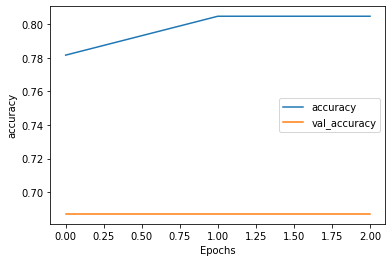

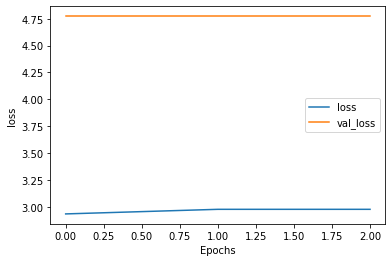

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Elections.csv')
test_encoded = bert_encode(test.REVIEWS)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()



In [ ]:
my_submission = pd.DataFrame({'sentiment': test.SENTIMENT, 'target': predicted_tweets_binary})

In [ ]:
my_submission

,sentiment,target
0,1,1
1,0,1
2,1,1
3,1,1
4,1,1
...,...,...
220,1,1
221,1,1
222,1,1
223,1,1


In [ ]:
history = model.fit(
    dev_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=test_dataset,
    verbose=2)

Epoch 1/3
4/4 - 194s - loss: 4.7737 - accuracy: 0.6870 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 194s/epoch - 48s/step
Epoch 2/3
4/4 - 193s - loss: 4.7737 - accuracy: 0.6870 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 193s/epoch - 48s/step
Epoch 3/3
4/4 - 192s - loss: 4.7737 - accuracy: 0.6870 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 192s/epoch - 48s/step
